In [435]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

Declaramos las constantes del problema

In [436]:
w = 2.6617e-6 #s^-1
G = 6.67e-11
d_TL = 3.844e8
M_T = 5.9736e24
M_L = 0.07349e24

R_T = 6.378160e6
R_L = 1.7374e6

delta = G*M_T/d_TL**3
nu = M_L/M_T

v_02 = 148
phi_init = np.pi/3

pphi = 0
pr = v_02**2

n_interation = int(10e4)

Asignamos la orbita para la Luna, y definimos las funciones con las ecuaciones diferenciales

In [437]:
@jit(nopython = True)
def polar_to_cart (r, phi):
    x = np.zeros((2, len(r)))
    for i in range(len(r)):
        x[0, i] = r[i] * np.cos(phi[i])
        x[1, i] = r[i] * np.sin(phi[i])
    return x

In [438]:
def coord_luna(h):
    x = np.zeros((2, n_interation))
    for i in range(n_interation):
        x[0, i] = np.cos(w*i*h)
        x[1, i] = np.sin(w*i*h)
    return x

Teniendo en cuenta que los vectores tienen la forma $\text{vec}_\text{Cohete} = (r, \phi, p_r, p_{\phi})$

In [439]:
@jit(nopython = True)
def function (vec_Cohete, t):
    r_prime = (1+vec_Cohete[0]**2-2*vec_Cohete[0]*np.cos(vec_Cohete[1]-w*t))**(1/2)
    
    r_dot = vec_Cohete[2]
    phi_dot = vec_Cohete[3]/(vec_Cohete[0]**2)
    pr_dot = (vec_Cohete[3]**2/vec_Cohete[0]**3) - delta * ((1/vec_Cohete[0]**2) + nu*(vec_Cohete[0]- np.cos(vec_Cohete[1]-w*t))/r_prime**3)
    pphi_dot = -delta*nu*vec_Cohete[0]*np.sin(vec_Cohete[1]-w*t)/r_prime**3
    
    return np.array([r_dot, phi_dot, pr_dot, pphi_dot])

Algoritmo para Runge-Kutta

In [440]:
@jit(nopython = True)
def Runge_Kutta (vec_Cohete, h, t):
    k_1 = h*function(vec_Cohete, t)
    k_2 = h*function(vec_Cohete + k_1/2, t + h/2)
    k_3 = h*function(vec_Cohete + k_2/2, t + h/2)
    k_4 = h*function(vec_Cohete + k_3, t + h)

    return vec_Cohete + (k_1 + k_2 + k_3 + k_4)/6

Añadimos una función para determinar el paso $h$, que tomar en cada momento

In [441]:
@jit(nopython = True)
def run_code_h_cte ():
    vec_Cohete_total = np.zeros((int(n_interation), 4))
    vec_Cohete_total[0] = np.array([R_T/d_TL, phi_init, pr/(2*d_TL), pphi/(d_TL**2)])
    t = 0
    h = 200
    for i in range(n_interation-1):
        vec_Cohete_total[i+1] = Runge_Kutta(vec_Cohete_total[i], h, t)
        t = t+ h
    return vec_Cohete_total

def run_code():
    vec_Cohete_total = np.zeros((int(n_interation), 4))
    vec_Cohete_total[0] = np.array([R_T/d_TL, phi_init, pr/(2*d_TL), pphi/(d_TL**2)])
    t = 0
    h = 60
    epsilon_max = h**5
    for i in range(n_interation-1):
        s = 10
        while (s > 2):
            y_h1 = Runge_Kutta(vec_Cohete_total[i], h/2, t)
            y_h2 = Runge_Kutta(y_h1, h/2, t )
            y_h = Runge_Kutta(vec_Cohete_total[i], h, t)
            epsilon = np.max(16*np.abs(y_h2-y_h)/15)
            s = np.max([((epsilon/epsilon_max)**0.2, 1e-8)])
            print(s)
            h_max = h/s
            print(h_max)
            if(s > 2):
                h = h_max   
            else:
                vec_Cohete_total[i+1] = y_h2
            if(h < h_max):
                h =2*h
            print(h)
        t = t+ h
    return vec_Cohete_total

In [442]:
vec_Cohete = run_code_h_cte()
pos_cohete = polar_to_cart(vec_Cohete[:,0], vec_Cohete[:,1])
pos_lunar = coord_luna(200)

In [443]:
f = open("datos.txt", "w")

for i in range(int(n_interation)):
    f.write(f"{pos_cohete[0, i]}, {pos_cohete[1, i]}\n")
    f.write(f"{pos_lunar[0, i]}, {pos_lunar[1, i]}\n")
    f.write(f"0, 0\n")
    f.write(f"\n")

f.close()

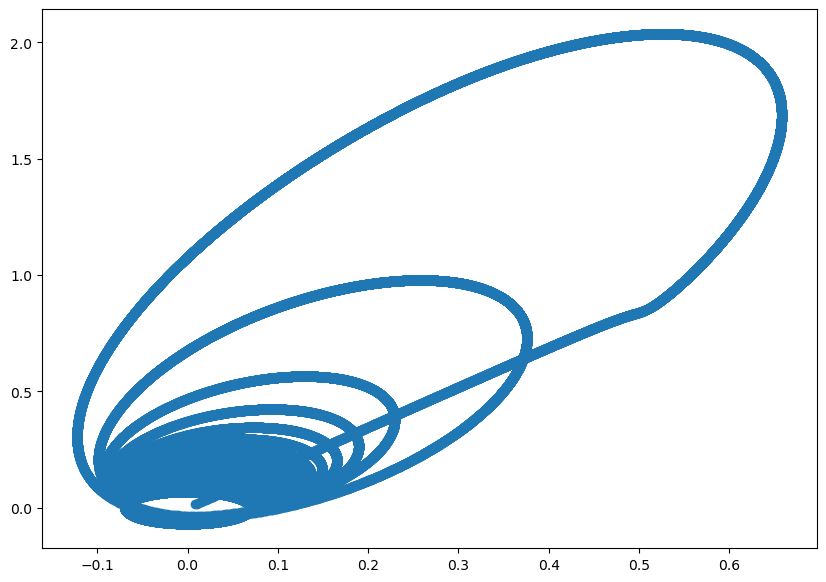

In [444]:
fig=plt.figure(figsize=(10,7)) #Size of the plot
ax=fig.add_subplot(111)

plt.scatter(pos_cohete[0], pos_cohete[1])